# Import

In [1]:
import sys, os, re, yaml, pickle
import commands
from glob import glob
from prettytable import PrettyTable
sys.path.append('../lib')

import time, datetime
from multiprocessing import Pool

In [2]:
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
from progressBar import ProgressBar

In [3]:
import uproot as ur
import ROOT as rt
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + 'Simulation Internal'
from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH2D, create_TH1D, std_color_list, SetMaxToMaxHist
from gridVarQ2Plot import col_dic, label_dic

rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Lumis, Handle, Events

Welcome to JupyROOT 6.12/07


In [4]:
def make_comp_plot_1D(inputs, #[x, label, color=-1 (auto), ]
                      transformX = None,
                      binning=[None, None, None],
                      setLog = '',
                      miny = 0,
                      axis_title = ['', ''],
                      scale_histo = 'norm',
                      opt='overflow+underflow',
                      leg_loc=[0.6, 0.7, 0.9, 0.93] # x0, y0, w, h
                     ): 
    
    if not leg_loc is None:
        leg = rt.TLegend(leg_loc[0], leg_loc[1], leg_loc[0] + leg_loc[2], leg_loc[1] + leg_loc[3])
        leg.SetBorderSize(0)
        leg.SetFillStyle(0)
        
    colors = []
    for p in inputs:
        if len(p) > 2:
            colors.append(p[2])
        else:
            colors.append(-1)
    jStd = 0
    for i,c in enumerate(colors):
        if c == -1:
            colors[i] = std_color_list[jStd]
            jStd += 1
    
    hList = []
    for i, p in enumerate(inputs):
        if transformX is None:
            x = p[0]
        else:
            x = transformX(p[0])
        label = p[1]
        h = create_TH1D(x, 
                        binning=binning if i==0 else hList[0].binning, 
                        axis_title=axis_title,
                        scale_histo=scale_histo, opt=opt,
                       )
        h.SetLineColor(colors[i])
        if not leg_loc is None:
            leg.AddEntry(h, label, 'lp')
        hList.append(h)
            
    m = SetMaxToMaxHist(hList)
    hList[0].GetYaxis().SetRangeUser(miny, m)
    c = drawOnCMSCanvas(CMS_lumi, hList, 'same')
    leg.Draw()
    
    if 'x' in setLog: c.SetLogx()
    if 'y' in setLog: c.SetLogy()
    
    c.dnd = [hList, leg]
    return c

# Inputs

In [5]:
base = '/storage/user/ocerri/BPhysics/data/cmsMC_private/'
loc = {}
# loc['tau'] = base + 'Unbiased_B0_TauNuDmst_Hardbbbar_evtgen_ISGW2_PUGENonly_10-2-3/test_GEN-SIM.root'
loc['tau'] = base + 'Unbiased_B0_TauNuDmst_Hardbbbar_evtgen_ISGW2_PUGENonly_10-2-3/jobs_out/out_GEN-SIM_*.root'
# loc['mu'] = base + 'Unbiased_B0_MuNuDmst_Hardbbbar_evtgen_ISGW2_PUGENonly_10-2-3/test_GEN-SIM.root'
loc['mu'] = base + 'Unbiased_B0_MuNuDmst_Hardbbbar_evtgen_ISGW2_PUGENonly_10-2-3/jobs_out/out_GEN-SIM_*.root'
loc['cuts_mu_SoftQCD'] = base + 'BP_Tag_B0_MuNuDmst_SoftQCDall_evtgen_ISGW2_PUGENonly_10-2-3/jobs_out/out_GEN-SIM_*.root'
loc['cuts_tau_MINIAOD'] = base + 'BP_Tag_B0_TauNuDmst_Hardbbbar_evtgen_ISGW2_PUGENonly_10-2-3/jobs_out/out_GEN-SIM_*.root'
loc['cuts_mu_MINIAOD'] = base + 'BP_Tag_B0_MuNuDmst_Hardbbbar_evtgen_ISGW2_PUGENonly_10-2-3/jobs_out/out_GEN-SIM_*.root'

In [6]:
handle = {}
handle['genFilter'] = [Handle('GenFilterInfo'), ('genFilterEfficiencyProducer', '', 'GEN')]
handle['genProduct'] = [Handle('GenLumiInfoProduct'), ('generator', '', 'GEN')]

In [7]:
eff = {}
for n, ftempl in loc.iteritems():
    print n.capitalize()
    N_cuts = 0
    N_gen = 0
    for fn in glob(ftempl):
        for lumi in Lumis(fn):
            prods = {}
            for k,v in handle.iteritems():
                lumi.getByLabel(v[1], v[0])
                prods[k] = v[0].product()
            N_cuts += prods['genFilter'].numEventsPassed()
            N_gen += prods['genFilter'].numEventsTotal()
           
    e, de = getEff(N_cuts, N_gen)
    eff[n] = [e, de]
    print 'eff generator: {:1.2e} +/- {:1.2e} ({:1.1e})'.format(e, de, de/e)
    print '\n'

Mu
eff generator: 4.01e-01 +/- 6.33e-04 (1.6e-03)


Tau
eff generator: 4.00e-01 +/- 6.33e-04 (1.6e-03)


Cuts_tau_miniaod
eff generator: 8.87e-04 +/- 2.43e-05 (2.7e-02)


Cuts_mu_softqcd
eff generator: 3.98e-05 +/- 4.99e-07 (1.3e-02)


Cuts_mu_miniaod
eff generator: 4.48e-03 +/- 5.45e-05 (1.2e-02)




# Extract informations from edm

In [8]:
def extractFromFile(inputs):
    iJob = inputs[0]
    fn = inputs[1]
    nMax = inputs[2]
    
    events = Events(fn)
    nTot = events.size()
    nOut = float(min(nTot, nMax))
    outDs = np.zeros((int(nOut), 4))
    for iEv, event in enumerate(events):
        if iEv ==0 or (iEv+1) % int(nOut/2.0) == 0:
            print '{}: {:.0f} %'.format(iJob, 100.*(iEv+1)/nOut)

        handle = Handle('vector<reco::GenParticle>')
        event.getByLabel(('genParticles', '', 'GEN'), handle)

        ptB = []
        etaB = []
        pt = []
        eta = []
        for p in handle.product():
            if not p.pdgId() == 511:
                continue
            ptB.append(p.pt())
            etaB.append(p.eta())
            for d in p.daughterRefVector():
                if d.pdgId() == -13:
                    pt.append(d.pt())
                    eta.append(d.eta())
                elif d.pdgId() == -15:
                    for dd in d.daughterRefVector():
                        if dd.pdgId() == -13:
                            pt.append(dd.pt())
                            eta.append(dd.eta())
        if len(pt) < 2:
            idx = 0
        else:
            pt = np.array(pt)
            eta = np.array(eta)
            sel = np.logical_and(pt > 6.7, np.abs(eta) < 1.6)

            if np.sum(sel) > 0:
                idx = np.random.choice(np.nonzero(sel)[0])
            else:
                idx = np.random.choice(pt.shape[0])
        outDs[iEv, 0] = pt[idx]
        outDs[iEv, 1] = eta[idx]
        outDs[iEv, 2] = ptB[idx]
        outDs[iEv, 3] = etaB[idx]

        if iEv == nMax - 1:
            break
    return [outDs, iEv+1]

In [28]:
nMax = 1e9
nFileMax = 100
dset = {}
nTot = {}
recreate = ['cuts_mu_SoftQCD', 'mu']

for n, ftmpl in loc.iteritems():
    if 'MINIAOD' in n: continue
    print n.capitalize()
    
    idx = ftmpl.find('10-2-3') + len('10-2-3')
    outname = ftmpl[:idx]+'/muonGenInfo.pkl'
    if os.path.exists(outname) and not n in recreate:
        print 'Loading file'
        nTot[n], outDs = pickle.load( open(outname, 'rb') )
    else:
        inputs = []
        for i, fn in enumerate(glob(ftmpl)):
            inputs.append([str(i), fn, nMax])
            if i == nFileMax-1:
                break
            
        p = Pool(min(20,len(inputs)))
        outputs = p.map(extractFromFile, inputs)
        outDs = np.concatenate(tuple([o[0] for o in outputs]))
        nTot[n] = np.sum([o[1] for o in outputs])
        
        pickle.dump( [nTot[n], outDs], open( outname, 'wb' ) )
    dset[n] = outDs

Mu
1: 0 %
19: 0 %
16: 0 %
3: 0 %
15: 0 %
7: 0 %
4: 0 %
14: 0 %
8: 0 %
18: 0 %
0: 0 %
10: 0 %
5: 0 %
6: 0 %
11: 0 %
9: 0 %
12: 0 %
17: 0 %
2: 0 %
13: 0 %
14: 50 %
13: 50 %
19: 50 %
10: 50 %
11: 50 %
5: 50 %
1: 50 %
16: 50 %
3: 50 %
4: 50 %
18: 50 %
2: 50 %
8: 50 %
15: 50 %
12: 50 %
6: 50 %
17: 50 %
7: 50 %
9: 50 %
0: 50 %
11: 100 %
5: 100 %
2: 100 %
10: 100 %
4: 100 %
3: 100 %
15: 100 %
6: 100 %
14: 100 %
0: 100 %
19: 100 %
1: 100 %
16: 100 %
13: 100 %
12: 100 %
8: 100 %
17: 100 %
18: 100 %
9: 100 %
7: 100 %
Tau
Loading file
Cuts_mu_softqcd
6: 6 %
18: 10 %
10: 8 %
4: 9 %
38: 14 %
36: 11 %
26: 10 %
8: 7 %
32: 8 %
20: 8 %
24: 6 %
34: 9 %
16: 5 %
30: 14 %
12: 7 %
2: 8 %
14: 14 %
28: 10 %
0: 10 %
22: 7 %
38: 43 %
38: 86 %
36: 44 %
4: 45 %
8: 50 %
39: 11 %
36: 89 %
26: 50 %
34: 45 %
37: 4 %
32: 50 %
18: 50 %
39: 44 %
30: 43 %
4: 91 %
20: 46 %
24: 50 %
8: 100 %
30: 86 %
39: 89 %
10: 46 %
34: 91 %
32: 100 %
26: 100 %
5: 7 %
2: 50 %
9: 5 %
33: 7 %
31: 6 %
27: 8 %
0: 50 %
37: 50 %
18: 100 %
28: 

In [29]:
print nTot

{'mu': 240853, 'tau': 240282, 'cuts_mu_SoftQCD': 1216}


# Analyze data

In [20]:
txt = rt.TLatex()
txt.SetTextAlign(12)
txt.SetTextSize(0.04)
txt.SetTextFont(42)

In [21]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

Mu
Total Gen Eff: 4.47e-03 +/- 8.61e-05
Tau
Total Gen Eff: 8.70e-04 +/- 3.81e-05


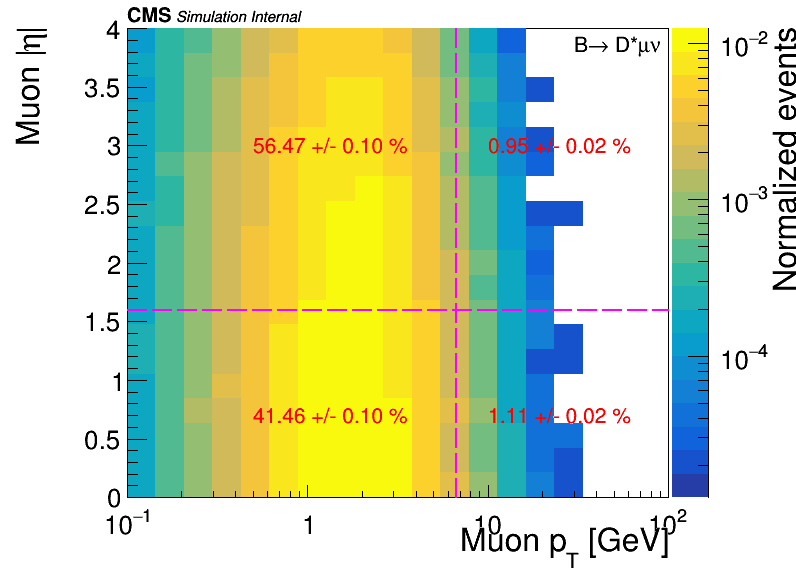

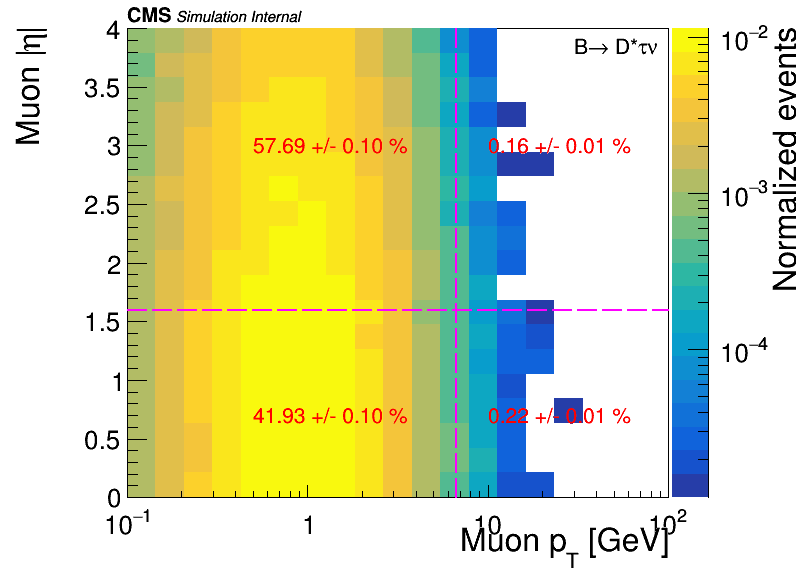

In [22]:
sel = {}
canvas = {}

for n in loc.keys():
    if 'cuts' in n: continue
    print n.capitalize()

    h2 = create_TH2D(np.column_stack((dset[n][:,0], np.abs(dset[n][:,1]))),
                     binning=[np.logspace(-1, 2, 20), np.linspace(0, 4, 20)],
                     scale_histo='norm',
                     axis_title=['Muon p_{T} [GeV]', 'Muon |#eta|', 'Normalized events']
                    )
    canvas[n] = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag=n, mR=0.16)
    canvas[n].SetLogx()
    canvas[n].SetLogz()

    cl.DrawLine(h2.binning[0][0], 1.6, h2.binning[0][-1], 1.6)
    cl.DrawLine(6.7, h2.binning[1][0], 6.7, h2.binning[1][-1])

    sel[n] = [dset[n][:,0] > 6.7, np.abs(dset[n][:,1]) < 1.6]
    sel[n].append(np.logical_and(sel[n][0], sel[n][1]))
    nSel = [np.sum(x) for x in sel[n]]

    txt.SetTextColor(2)
    e, de = getEff(nSel[2], nTot[n])
    txt.DrawLatex(10, 0.7, '{:.2f} +/- {:.2f} %'.format(100*e, 100*de))
    e, de = getEff(nSel[0] - nSel[2], nTot[n])
    txt.DrawLatex(10, 3, '{:.2f} +/- {:.2f} %'.format(100*e, 100*de))
    e, de = getEff(nSel[1] - nSel[2], nTot[n])
    txt.DrawLatex(0.5, 0.7, '{:.2f} +/- {:.2f} %'.format(100*e, 100*de))
    e, de = getEff(nTot[n] - nSel[0] - nSel[1] + nSel[2], nTot[n])
    txt.DrawLatex(0.5, 3, '{:.2f} +/- {:.2f} %'.format(100*e, 100*de))

    txt.SetTextColor(1)
    txt.DrawLatex(30, 3.85, label_dic[n])

    e, de = getEff(nSel[2], nTot[n]/eff[n][0])
    print 'Total Gen Eff: {:1.2e} +/- {:1.2e}'.format(e, de)

<ROOT.TCanvas object ("c") at 0x7a5a20e0>

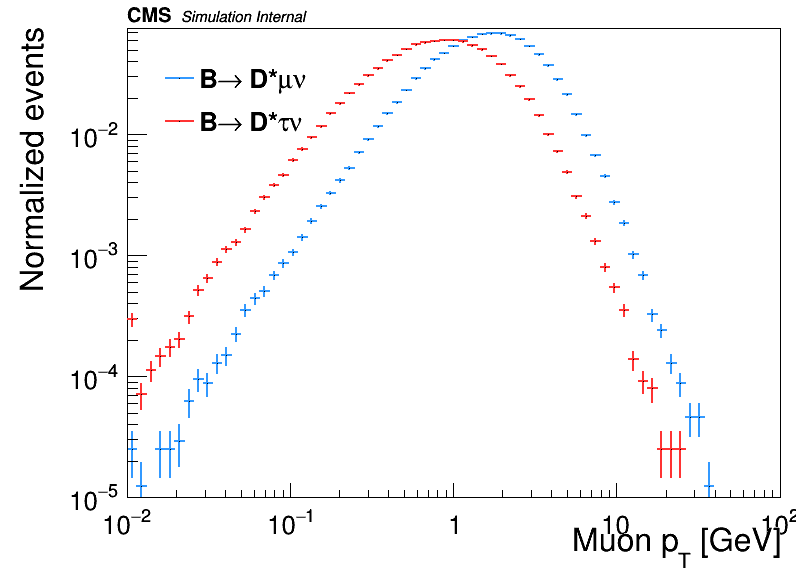

In [23]:
make_comp_plot_1D(
    [
        [dset['mu'][:,0], label_dic['mu']],
        [dset['tau'][:,0], label_dic['tau']],
    ],
    binning=np.logspace(-2, 2, 70), setLog='xy', miny=1e-5,
    axis_title = ['Muon p_{T} [GeV]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.2, 0.15]
)


<ROOT.TCanvas object ("c") at 0x7a608b30>

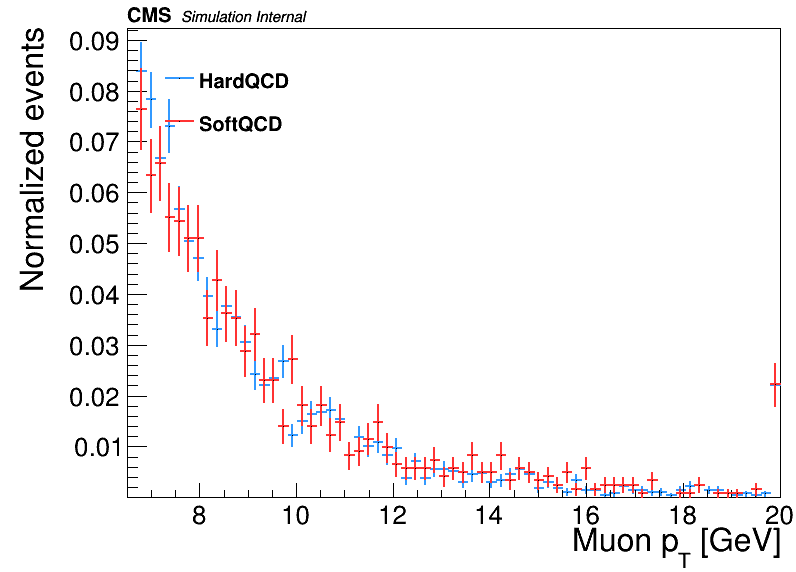

In [26]:
sel = np.logical_and(dset['mu'][:,0]>6.7, np.abs(dset['mu'][:,1])<1.6)
make_comp_plot_1D(
    [
        [dset['mu'][:,0][sel], 'HardQCD'],
        [dset['cuts_mu_SoftQCD'][:,0], 'SoftQCD'],
    ],
    binning=np.linspace(6.5, 20, 70), setLog='', miny=1e-5,
    axis_title = ['Muon p_{T} [GeV]', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.2, 0.15]
)

<ROOT.TCanvas object ("c") at 0x7a609fa0>

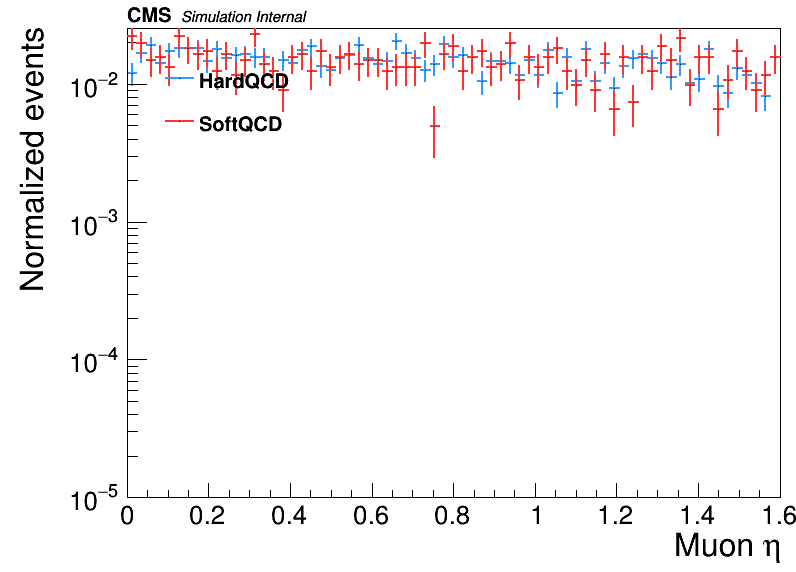

In [25]:
sel = np.logical_and(dset['mu'][:,0]>6.7, np.abs(dset['mu'][:,1])<1.6)
make_comp_plot_1D(
    [
        [np.abs(dset['mu'][:,1][sel]), 'HardQCD'],
        [np.abs(dset['cuts_mu_SoftQCD'][:,1]), 'SoftQCD'],
    ],
    binning=np.linspace(0, 1.6, 70), setLog='y', miny=1e-5,
    axis_title = ['Muon #eta', 'Normalized events'],
    leg_loc=[0.2, 0.75, 0.2, 0.15]
)

<ROOT.TCanvas object ("c") at 0x7a3079a0>

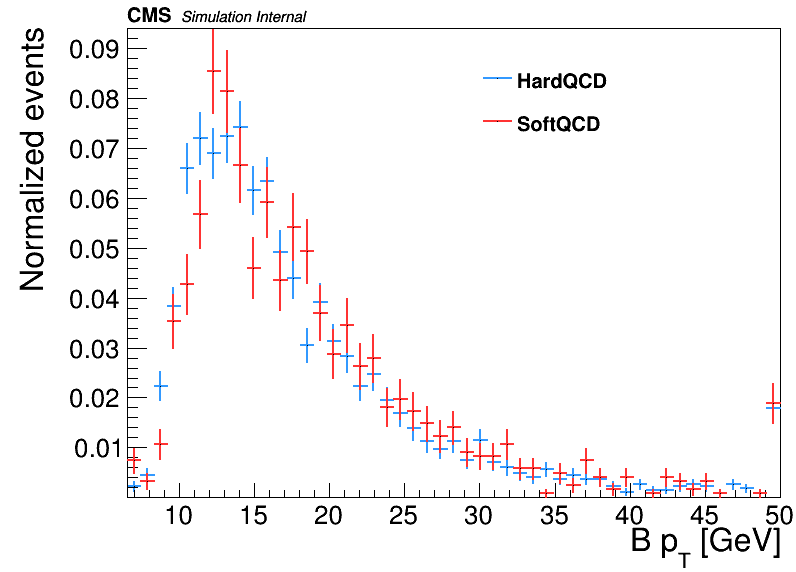

In [33]:
sel = np.logical_and(dset['mu'][:,0]>6.7, np.abs(dset['mu'][:,1])<1.6)
make_comp_plot_1D(
    [
        [dset['mu'][:,2][sel], 'HardQCD'],
        [dset['cuts_mu_SoftQCD'][:,2], 'SoftQCD'],
    ],
    binning=np.linspace(6.5, 50, 50), setLog='', miny=1e-5,
    axis_title = ['B p_{T} [GeV]', 'Normalized events'],
    leg_loc=[0.6, 0.75, 0.2, 0.15]
)

<ROOT.TCanvas object ("c") at 0x7a5e05d0>

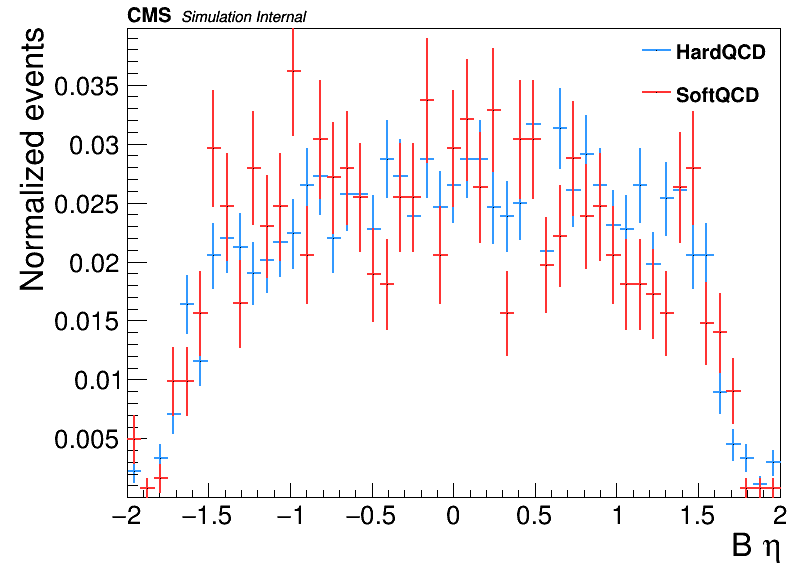

In [36]:
make_comp_plot_1D(
    [
        [dset['mu'][:,3][sel], 'HardQCD'],
        [dset['cuts_mu_SoftQCD'][:,3], 'SoftQCD'],
    ],
    binning=np.linspace(-2, 2, 50), setLog='', miny=1e-5,
    axis_title = ['B #eta', 'Normalized events'],
    leg_loc=[0.8, 0.8, 0.2, 0.15]
)